In [10]:
from nutils import function, mesh, solver
from nutils.expression_v2 import Namespace
import numpy as np
# np.set_printoptions(precision=4, suppress=True)
from matplotlib import pyplot as plt
# from consts import *
import json
import scipy.linalg as la

with open('consts.json', 'r') as json_file:
    consts = json.load(json_file)
    

# Parameters
MMF_i = 105                     # Imposed MMF = N*i
l = np.array([11, 2, 15, 2]) * 1e-3   # Region thickness in [m]
mu_r = np.array([1, 1, 2, 1])      # Relative permeability of each domain

# l = np.array([5.3, 1, 5, 1]) * 1e-3   # Region thickness in [m]
# mu_r = np.array([1, 1, 10, 1])      # Relative permeability of each domain
mu0 = 1.257 * 10**-6           # Permeability of free space
mu_lst = mu0 * mu_r
# Calculation variables
MMF = np.array([0, MMF_i, 0, -MMF_i]) # MMF in each domain
interfaces_global = np.concatenate(([0], np.cumsum(l)))  # Radii of boundaries including origin

# Calculation variables

Jz_lst = MMF / (np.pi * (interfaces_global[1:]**2 - interfaces_global[:-1]**2))  # Current density in each domain
print("Jz_lst:", Jz_lst)

plt.style.use("default")

def find_region(value):
    # print(interfaces_global)
    r1, r2, r3, r4 = interfaces_global[1], interfaces_global[2], interfaces_global[3], interfaces_global[4]
    # print("r1, r2, r3, r4", r1, r2, r3, r4)
    # print("Value", value)

    # 判断值落在哪个区间
    if 0 <= value < r1: 
        return int(0)
    elif r1 <= value < r2:
        return int(1)
    elif r2 <= value < r3:
        return int(2)
    elif r3 <= value <= r4:
        return int(3)
    else:
        raise ValueError("Value {} is less than 0 or larger than r4".format(value))

class exact_fn():
    def __init__(self,):
        self.name = "RHS"
        self.scale = [0, 1]
        self.mu0 = 1.257*10**-6 # H/m

    def __call__(self, x):
        single_value = np.isscalar(x)
        if single_value:
            x = np.array([x])

        result = np.zeros_like(x, dtype=float)
        for i in range(len(x)):
            x_ = x[i]
            region = find_region(x_)
            Param = consts["Params"][region]
            self.A0 = Param["A"]
            self.B0 = Param["B"]
            self.mu = Param["mu"]
            self.Jz = Param["Jz"]
            self.muJz = self.mu * self.mu0 * self.Jz
            if x_ != 0:
                func1 = self.A0 + self.B0*np.log(x_) - 1/4 * self.muJz * x_**2 
            else:
                func1 = self.A0 - 1/4 * self.muJz * x_**2 
            result[i] = func1

        return result[0] * 1e6 if single_value else result * 1e6

Jz_lst: [       0.          2881253.2801119         0.         -1416209.23937703]


In [11]:


def assemble(M_1, M_2):
    if M_1.ndim == 2:
        size_new = (M_1.shape[0] + M_2.shape[0] - 1, M_1.shape[1] + M_2.shape[1] - 1)
        new_M = np.zeros(size_new)
        new_M[:M_1.shape[0], :M_1.shape[1]] += M_1
        new_M[M_1.shape[0]-1:, M_1.shape[1]-1:] += M_2
        
    # 检查 M_1 是否为向量
    elif M_1.ndim == 1:
        length_new = (M_1.shape[0] + M_2.shape[0] - 1, 1)
        new_M = np.zeros(length_new)
        new_M[:M_1.shape[0]] += M_1.reshape(-1, 1)
        new_M[M_1.shape[0]-1:] += M_2.reshape(-1, 1)
        
    else:
        raise ValueError("M_1 must be either a matrix (2D array) or a vector (1D array).")
        
    return new_M

def creat_mesh(num_elems_per_segment = 1  ):
    interfaces = interfaces_global
    mesh = np.array([])

    for i in range(len(interfaces)-1):
        start, end = interfaces[i], interfaces[i+1]

        sub_mesh = np.linspace(start, end, num_elems_per_segment + 1)
        if i > 0:
            sub_mesh = sub_mesh[1:]  

        mesh = np.concatenate((mesh, sub_mesh))
        
    mesh_lst = []
    interfaces = interfaces_global

    for i in range(len(interfaces)-1):

        this_mesh = np.linspace(interfaces[i], interfaces[i+1], num_elems_per_segment+1)
        mesh_lst.append((this_mesh))

    return mesh, mesh_lst

mesh_global, mesh_global_lst = creat_mesh(1)
print(mesh_global)

mesh.rectilinear([mesh_global])
topo, geom = mesh.rectilinear([mesh_global])

topo.boundary['left']
basis = topo.basis('spline', degree=1)
print(basis.shape)

[0.     0.0053 0.0063 0.0113 0.0123]
(5,)


In [12]:
def K_F_subdomain(submesh, section):
    i = section

    this_mu = float(mu_lst[i])

    this_Jz = float(Jz_lst[i])

    topo, geom = mesh.rectilinear([submesh])

    ns = Namespace()

    ns.x = geom

    ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', "dS"))

    ns.basis = topo.basis('spline', degree=1)

    ns.u = function.dotarg('lhs', ns.basis)

    ns.invsmu = 1 / this_mu
    print("this_mu", this_mu)

    ns.mu = this_mu

    ns.Jz = this_Jz

    # M = topo.integral('x_0 ∇_i(basis_m) ∇_i(basis_n) dV' @ ns, degree=1).eval()

    # K = M.export('dense')

    # F = topo.integral('mu Jz x_0 basis_n dV' @ ns, degree=1).eval().reshape(-1, 1)

    M = topo.integral('x_0 invsmu ∇_i(basis_m) ∇_i(basis_n) dV' @ ns, degree=1).eval()

    K = M.export('dense')

    F = topo.integral('x_0 basis_n Jz dV' @ ns, degree=1).eval().reshape(-1, 1)

    return K, F


def FEM(mesh_global_lst, verbose = False):

    K_lst = []

    F_lst = []

    for i in range(len(mesh_global_lst)):

        # print(this_mu, this_Jz)

        K_sub, F_sub = K_F_subdomain(mesh_global_lst[i], i)

        K_lst.append(K_sub)

        F_lst.append(F_sub)

        print("Fsub:", F_sub)

        if i == 0:

            K = K_sub

            F = F_sub

        else:

            K = assemble(K, K_sub)

            F = assemble(F, F_sub)

    K[-1, -1] = 1

    K[-1,  0:-1] = 0.0

    K[0:-1,  -1] = 0.0

    F[-1] = 0

    U = la.solve(K, F)

    if verbose:

        print("K:\n", K)

        print("F:\n", F)

        print("U:\n", U)

    return K, F, U





this_mu 1.2569999999999998e-06
Fsub: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
this_mu 1.2569999999999998e-06
Fsub: [[1.95384988]
 [3.99773893]
 [4.17781726]
 [4.35789559]
 [2.22396738]]
this_mu 1.2569999999999998e-05
Fsub: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
this_mu 1.2569999999999998e-06
Fsub: [[-2.02252382]
 [-4.08930418]
 [-4.17781726]
 [-4.26633033]
 [-2.15529344]]
interface (mm) ['0', '5', '6', '11', '12']


([<matplotlib.axis.XTick at 0x214d3c42d30>,
 [Text(0.0, 0, '0'),
  Text(0.0053, 0, '5'),
  Text(0.0063, 0, '6'),
  Text(0.011300000000000001, 0, '11'),
  Text(0.012300000000000002, 0, '12')])

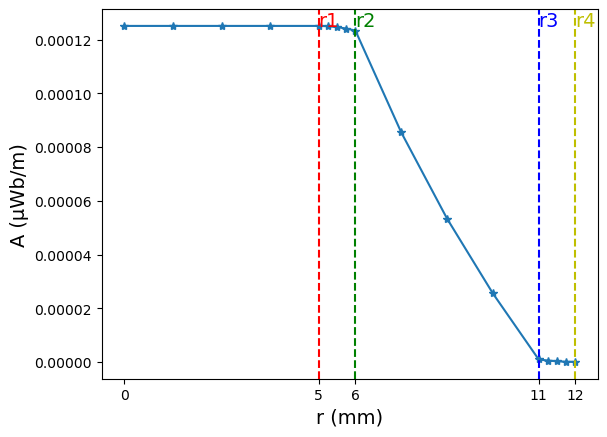

In [13]:
verbose = False
num_elems = 4

mesh_global, mesh_global_lst = creat_mesh(num_elems)
K, F, U = FEM(mesh_global_lst, verbose)
exact_func = exact_fn()
x_global = np.linspace(0, interfaces_global[-1], 5000)
interfaces_mm = []
for i in interfaces_global:
    interfaces_mm.append("{}".format(int(i*1000)))
print("interface (mm)",interfaces_mm)
# x_plot = mesh_global
u_exact = exact_func(x_global)


# np.savez("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/datasets/Poission.npz", r=x_global, solution=u_exact)
# plt.plot(x_global, u_exact, label="Exact solution") 
plt.plot(mesh_global, U, "*-", label = "FEA solution with \n num_elems = {}".format(num_elems),)

max_U = max(U)
max_plot = max_U
r1, r2, r3, r4 = interfaces_global[1], interfaces_global[2], interfaces_global[3], interfaces_global[4]
fontsize = 14
plt.axvline(x=r1, color='r', linestyle='--') 
plt.text(r1, max_plot, "r1", fontsize=14, color='r')
plt.axvline(x=r2, color='g', linestyle='--') 

plt.text(r2, max_plot, "r2", fontsize=14, color='g')
plt.axvline(x=r3, color='b', linestyle='--') 
plt.text(r3, max_plot, "r3", fontsize=14, color='b')
plt.axvline(x=r4, color='y', linestyle='--') 
plt.text(r4, max_plot, "r4", fontsize=14, color='y')
plt.xlabel("r (mm)", fontsize =fontsize)
plt.ylabel("A (µWb/m)", fontsize=fontsize)
plt.xticks(ticks=interfaces_global, labels=interfaces_mm)
# plt.ylim(0, 1)
# plt.legend()
# # plt.savefig("FEM_{}".format(num_elems))
# print("U, u_exact", U[0], u_exact[0])
# # np.savez("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe_nutils/datasets/Poission_FEM.npz", r=mesh_global, solution=U)


In [14]:
U[0]

array([0.00012512])